<a href="https://colab.research.google.com/github/ImanNoferesti/3D_DataVisualizer_VR/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Component 1:

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [7]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



## Split the data to training, testing, and validation subsets

In [8]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)

# Step 1: Split into 80% train+validation and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

# Step 2: Split the 80% train+validation into 70% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=1) # 0.125 of 80% is 10%

# Verifying the shapes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


Training set size: 10346
Validation set size: 1478
Test set size: 2956


## Accuracy of a classifier

In [9]:
def testLinearClassifier(a, X, y):
    """
    Tests the performance of a linear classifier.

    Parameters:
    a (numpy array): The weight vector of the linear classifier (including bias).
    X (numpy array): The feature matrix (test dataset).
    y (numpy array): The true labels corresponding to the test dataset.

    Returns:
    int: The number of misclassified points.
    """
    # Augment X with a column of ones for the bias term
    X_augmented = np.hstack((X, np.ones((X.shape[0], 1))))

    # Compute predictions using the linear classifier
    predictions = np.sign(X_augmented @ a)  # Predicts -1 or +1 for binary classification

    # Ensure labels match prediction format (-1 or +1 for comparison)
    y_transformed = np.where(y == 0, -1, 1)

    # Count misclassified points
    misclassifications = np.sum(predictions.flatten() != y_transformed)

    return misclassifications



### Define and test gaussianClassifierWithIdentityCovariance

Training misclassifications: 70
Validation misclassifications: 14
Test misclassifications: 29


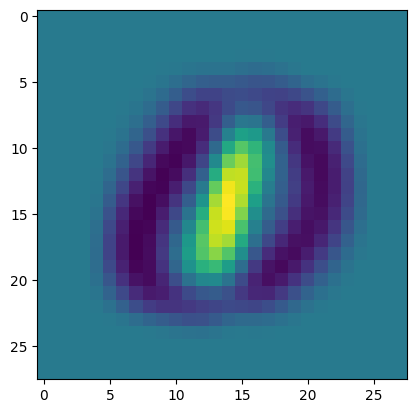

In [10]:
def gaussianClassifierWithIdentityCovariance(Xtrain, ytrain):
    """
    Trains a Gaussian classifier with an identity covariance matrix (Σ = I).

    Parameters:
    Xtrain (numpy array): Training dataset (features).
    ytrain (numpy array): Training labels (0 or 1).

    Returns:
    numpy array: The weight vector `a` for the linear discriminant function.
    """
    a = 0.01 * np.random.randn(Nfeatures + 1, 1)

    # Estimate the means for each class
    mu1 = np.mean(Xtrain[ytrain == 0], axis=0)  # Mean vector for class 0
    mu2 = np.mean(Xtrain[ytrain == 1], axis=0)  # Mean vector for class 1

    # Compute the weight vector a for the classifier
    a_linear = mu2 - mu1  # Linear term (difference of means)
    a_bias = -0.5 * (np.dot(mu2, mu2) - np.dot(mu1, mu1))  # Bias term

    # Concatenate weights and bias into a single vector
    a = np.zeros((Xtrain.shape[1] + 1, 1))
    a[:-1, 0] = a_linear
    a[-1, 0] = a_bias

    return a


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

print(f"Training misclassifications: {train}")
print(f"Validation misclassifications: {val}")
print(f"Test misclassifications: {test}")



### Define and test gaussianClassifierWithCommonCovariance

Training misclassifications: 48
Validation misclassifications: 19
Test misclassifications: 22


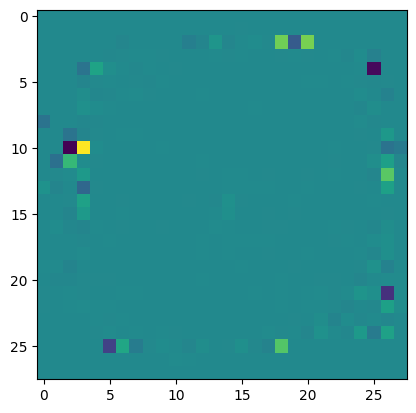

In [11]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain, ytrain, regularization=1e-5):
    """
    Trains a Gaussian classifier with a regularized common covariance matrix Σ.

    Parameters:
    Xtrain (numpy array): Training dataset (features).
    ytrain (numpy array): Training labels (0 or 1).
    regularization (float): Regularization term added to the diagonal of Σ.

    Returns:
    numpy array: The weight vector `a2` for the linear discriminant function.
    """
    # Estimate the means for each class
    mu1 = np.mean(Xtrain[ytrain == 0], axis=0)  # Mean vector for class 0
    mu2 = np.mean(Xtrain[ytrain == 1], axis=0)  # Mean vector for class 1

    # Estimate the common covariance matrix Σ
    X1 = Xtrain[ytrain == 0] - mu1  # Centered data for class 0
    X2 = Xtrain[ytrain == 1] - mu2  # Centered data for class 1
    Sigma = (np.dot(X1.T, X1) + np.dot(X2.T, X2)) / Xtrain.shape[0]  # Pooled covariance

    # Regularize Σ by adding a small value to the diagonal
    Sigma += regularization * np.eye(Sigma.shape[0])  # Ensure invertibility

    # Compute the inverse of Σ
    Sigma_inv = np.linalg.inv(Sigma)

    # Compute the weight vector a for the classifier
    a_linear = np.dot(Sigma_inv, (mu2 - mu1))  # Linear term
    a_bias = -0.5 * (np.dot(mu2.T, np.dot(Sigma_inv, mu2)) - np.dot(mu1.T, np.dot(Sigma_inv, mu1)))  # Bias term

    # Concatenate weights and bias into a single vector
    a = np.zeros((Xtrain.shape[1] + 1, 1))
    a[:-1, 0] = a_linear
    a[-1, 0] = a_bias

    return a




# ------ SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train, y_train)
plt.imshow(np.reshape(a[:-1], (28, 28)))  # Visualize the weights (excluding the bias)

train_misclassifications = testLinearClassifier(a, X_train, y_train)
val_misclassifications = testLinearClassifier(a, X_val, y_val)
test_misclassifications = testLinearClassifier(a, X_test, y_test)

print(f"Training misclassifications: {train_misclassifications}")
print(f"Validation misclassifications: {val_misclassifications}")
print(f"Test misclassifications: {test_misclassifications}")


### Define and test logisticRegression

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors

Training misclassifications: 12
Validation misclassifications: 2
Test misclassifications: 7


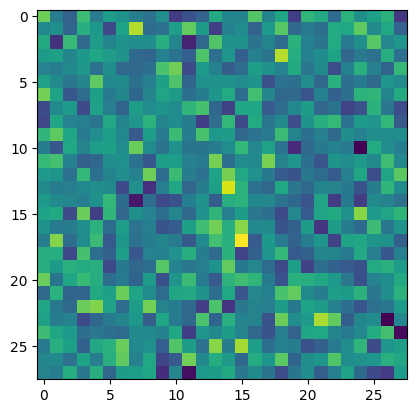

In [12]:
def logisticRegression(Xtrain, ytrain, iterations=100, step_size=1e-4, verbose=False):
    """
    Trains a logistic regression classifier using gradient descent.

    Parameters:
    Xtrain (numpy array): Training dataset (features).
    ytrain (numpy array): Training labels (0 or 1).
    iterations (int): Number of gradient descent iterations.
    step_size (float): Learning rate for gradient descent.
    verbose (bool): If True, prints progress every 10 iterations.

    Returns:
    numpy array: The weight vector `a3` for the logistic regression model.
    """
    # Append a bias term (column of 1s) to the training data
    Xtrain_augmented = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    # Initialize weights (including bias) randomly
    a = 0.01 * np.random.randn(Xtrain_augmented.shape[1], 1)

    # Reshape ytrain to match dimensions (needed for matrix operations)
    ytrain = ytrain.reshape(-1, 1)

    for i in range(iterations):
        # Compute predictions using the sigmoid function
        predictions = expit(Xtrain_augmented @ a)  # Sigmoid function

        # Compute the gradient of the log-likelihood
        gradient = Xtrain_augmented.T @ (predictions - ytrain) / Xtrain.shape[0]

        # Update weights using gradient descent
        a -= step_size * gradient

        # Print progress if verbose
        if verbose and i % 10 == 0:
            loss = -np.mean(ytrain * np.log(predictions + 1e-9) + (1 - ytrain) * np.log(1 - predictions + 1e-9))
            print(f"Iteration {i}: Loss = {loss}")

    return a


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

print(f"Training misclassifications: {train}")
print(f"Validation misclassifications: {val}")
print(f"Test misclassifications: {test}")




Training misclassifications: 7
Validation misclassifications: 3
Test misclassifications: 9


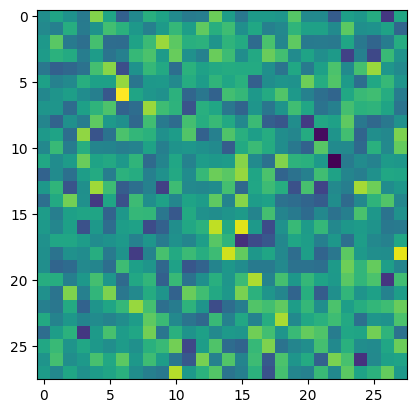

In [13]:
def logisticRegressionWithRegularization(Xtrain, ytrain, iterations=100, step_size=1e-4, lam=0, verbose=False):
    """
    Trains a regularized logistic regression classifier using gradient descent.

    Parameters:
    Xtrain (numpy array): Training dataset (features).
    ytrain (numpy array): Training labels (0 or 1).
    iterations (int): Number of gradient descent iterations.
    step_size (float): Learning rate for gradient descent.
    lam (float): Regularization parameter (λ).
    verbose (bool): If True, prints progress every 10 iterations.

    Returns:
    numpy array: The weight vector `a` for the logistic regression model.
    """
    # Append a bias term (column of 1s) to the training data
    Xtrain_augmented = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    # Initialize weights (including bias) randomly
    a = 0.01 * np.random.randn(Xtrain_augmented.shape[1], 1)

    # Reshape ytrain to match dimensions (needed for matrix operations)
    ytrain = ytrain.reshape(-1, 1)

    for i in range(iterations):
        # Compute predictions using the sigmoid function
        predictions = expit(Xtrain_augmented @ a)  # Sigmoid function

        # Compute the gradient of the regularized log-likelihood
        gradient = (Xtrain_augmented.T @ (predictions - ytrain)) / Xtrain.shape[0]
        gradient[:-1] += lam * a[:-1]  # Add regularization term for weights (not bias)

        # Update weights using gradient descent
        a -= step_size * gradient

        # Print progress if verbose
        if verbose and i % 10 == 0:
            loss = -np.mean(
                ytrain * np.log(predictions + 1e-9) + (1 - ytrain) * np.log(1 - predictions + 1e-9)
            ) + (lam / (2 * Xtrain.shape[0])) * np.sum(a[:-1] ** 2)  # Regularized loss
            print(f"Iteration {i}: Loss = {loss}")

    return a



#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

print(f"Training misclassifications: {train}")
print(f"Validation misclassifications: {val}")
print(f"Test misclassifications: {test}")



In [14]:
# def optimizeHyperparameters(Xtrain, ytrain):
#     """
#     Optimize the regularization parameter (λ) for logistic regression with regularization.

#     Parameters:
#     Xtrain (tuple): Tuple containing the training dataset (Xtrain) and validation dataset (Xval), along with labels (ytrain, yval).

#     Returns:
#     float: Optimal λ value (lamopt).
#     """
#     # Unpack the training and validation datasets
#     X_train, X_val, y_train, y_val = Xtrain

#     # Define a range of λ values to evaluate
#     lambdas = [0.01, 0.1, 1, 10, 100]

#     # Initialize variables to track the best λ and minimum misclassifications
#     lamopt = None
#     min_misclassifications = float('inf')

#     # Iterate over each λ value
#     for lam in lambdas:
#         # Train logistic regression with the current λ
#         a = logisticRegressionWithRegularization(X_train, y_train, iterations=500, step_size=1e-4, lam=lam, verbose=False)

#         # Test on the validation set
#         val_misclassifications = testLinearClassifier(a, X_val, y_val)

#         # Update the best λ if the current one performs better
#         if val_misclassifications < min_misclassifications:
#             min_misclassifications = val_misclassifications
#             lamopt = lam

#     return lamopt


# # Prepare the training and validation datasets
# Xtrain_tuple = (X_train, X_val, y_train, y_val)

# # Optimize λ
# optimal_lambda = optimizeHyperparameters(Xtrain_tuple, y_train)

# print(f"Optimal λ: {optimal_lambda}")



In [15]:
def optimizeHyperparameters(X_train, y_train, X_val, y_val):
    """
    Optimize the regularization parameter (λ) for logistic regression with regularization.

    Parameters:
    X_train (ndarray): Training dataset features.
    y_train (ndarray): Training dataset labels.
    X_val (ndarray): Validation dataset features.
    y_val (ndarray): Validation dataset labels.

    Returns:
    float: Optimal λ value (lamopt).
    """
    # Define a range of λ values to evaluate
    lambdas = [0.01, 0.1, 1, 10, 100]

    # Initialize variables to track the best λ and minimum misclassifications
    lamopt = None
    min_misclassifications = float('inf')

    # Iterate over each λ value
    for lam in lambdas:
        # Train logistic regression with the current λ
        a = logisticRegressionWithRegularization(X_train, y_train, iterations=500, step_size=1e-4, lam=lam, verbose=False)

        # Test on the validation set
        val_misclassifications = testLinearClassifier(a, X_val, y_val)

        # Update the best λ if the current one performs better
        if val_misclassifications < min_misclassifications:
            min_misclassifications = val_misclassifications
            lamopt = lam

    return lamopt


## REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [16]:
# Compare performance of all classifiers

# First, we assume that we already have X_train, y_train, X_val, y_val, X_test, y_test from previous steps

# Train and test Gaussian Classifier with Identity Covariance
a1 = gaussianClassifierWithIdentityCovariance(X_train, y_train)
print(a1.shape)
misclassifications_a1 = testLinearClassifier(a1, X_test, y_test)
print(f"Misclassifications with Gaussian Classifier (Identity Covariance): {misclassifications_a1}")

# Train and test Gaussian Classifier with Common Covariance
a2 = gaussianClassifierWithCommonCovariance(X_train, y_train)
misclassifications_a2 = testLinearClassifier(a2, X_test, y_test)
print(f"Misclassifications with Gaussian Classifier (Common Covariance): {misclassifications_a2}")

# Train and test Logistic Regression
a3 = logisticRegression(X_train, y_train, iterations=500, step_size=1e-4, verbose=False)
misclassifications_a3 = testLinearClassifier(a3, X_test, y_test)
print(f"Misclassifications with Logistic Regression: {misclassifications_a3}")

# Optimize λ for Regularized Logistic Regression
optimal_lambda = optimizeHyperparameters(X_train, y_train, X_val, y_val)  # Pass X_train, y_train, X_val, y_val
print(f"Optimal λ: {optimal_lambda}")
a4 = logisticRegressionWithRegularization(X_train, y_train, iterations=500, step_size=1e-4, lam=optimal_lambda, verbose=False)
misclassifications_a4 = testLinearClassifier(a4, X_test, y_test)
print(f"Misclassifications with Regularized Logistic Regression (λ = {optimal_lambda}): {misclassifications_a4}")


(785, 1)
Misclassifications with Gaussian Classifier (Identity Covariance): 29
Misclassifications with Gaussian Classifier (Common Covariance): 22
Misclassifications with Logistic Regression: 6
Optimal λ: 0.1
Misclassifications with Regularized Logistic Regression (λ = 0.1): 6


# Component 2:

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [32]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



## Split the data to training, testing, and validation subsets

In [33]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)

# Step 1: Split into 80% train+validation and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

# Step 2: Split the 80% train+validation into 70% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=1) # 0.125 of 80% is 10%

# Verifying the shapes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


Training set size: 10346
Validation set size: 1478
Test set size: 2956


## Multi-class Classifiers

### Define and test gaussianMultiChannelClassifierWithIdentityCovariance

In [34]:
# def gaussianMultiChannelClassifier(X_train, y_train):
#     """
#     Multi-class Gaussian Classifier with shared covariance matrix Σ = I.

#     Parameters:
#         X_train (numpy.ndarray): Training dataset, shape (n_samples, n_features).
#         y_train (numpy.ndarray): Training labels, shape (n_samples,).

#     Returns:
#         np.ndarray: Matrix A1, where each column corresponds to ai for discriminants yi(x).
#     """
#     classes = np.unique(y_train)  # Get unique class labels
#     n_classes = len(classes)
#     n_features = X_train.shape[1]

#     # Initialize means for each class
#     means = np.zeros((n_classes, n_features))

#     # Compute the mean vector μi for each class i
#     for i, cls in enumerate(classes):
#         means[i, :] = np.mean(X_train[y_train == cls], axis=0)

#     # Prepare the discriminant function values
#     # The shared covariance Σ = I simplifies the discriminant calculation to:
#     # yi(x) = -0.5 * ||x - μi||^2
#     # (ignoring constant terms and log priors for simplicity)
#     def discriminant(x, mu):
#         return -0.5 * np.linalg.norm(x - mu)**2

#     # Calculate discriminants for all samples
#     n_samples = X_train.shape[0]
#     A1 = np.zeros((n_classes, n_samples))

#     for i, cls in enumerate(classes):
#         mu = means[i, :]
#         for j in range(n_samples):
#             A1[i, j] = discriminant(X_train[j, :], mu)

#     return A1



# A1 = gaussianMultiChannelClassifier(X_train, y_train)

# # Verify the dimensions of the output
# print("A1 shape:", A1.shape)  # Should be (n_classes, n_samples)




In [35]:
def gaussianMultiChannelClassifier(X_train, y_train):
    """
    Implements the multiclass Gaussian classifier assuming a common covariance matrix (Σ = I).

    Parameters:
        X_train (numpy.ndarray): Training data of shape (n_samples, n_features).
        y_train (numpy.ndarray): Labels corresponding to the training data.
        num_classes (int): Number of unique classes in the dataset.

    Returns:
        numpy.ndarray: Matrix A1 of shape (n_features, num_classes), where each column corresponds
                       to the discriminant coefficients a_i.
    """
    n_features = X_train.shape[1]
    num_classes = 2
    A1 = np.zeros((n_features, num_classes))

    # Compute mean vector for each class
    for i in range(num_classes):
        class_data = X_train[y_train == i]
        mu_i = np.mean(class_data, axis=0)
        A1[:, i] = mu_i  # Since Σ = I, w_i = μ_i

    return A1

# Example usage
A1 = gaussianMultiChannelClassifier(X_train, y_train)

print("Matrix A1:")
print(A1)
print("Shape of A1:", A1.shape)

Matrix A1:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Shape of A1: (784, 2)


### Define and test logisticRegressionMultiClassClassifier


In [36]:
# def softmax(z):
#     """
#     Compute the softmax for each column of the input array z.

#     Parameters:
#         z (numpy.ndarray): Logits array, shape (n_classes, n_samples).

#     Returns:
#         numpy.ndarray: Softmax probabilities, shape (n_classes, n_samples).
#     """
#     exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Stability improvement
#     return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# def cross_entropy_loss(y_true, y_pred):
#     """
#     Compute the cross-entropy loss.

#     Parameters:
#         y_true (numpy.ndarray): True labels, shape (n_samples,).
#         y_pred (numpy.ndarray): Predicted probabilities, shape (n_classes, n_samples).

#     Returns:
#         float: Cross-entropy loss.
#     """
#     # Ensure y_true is an integer array
#     y_true = y_true.astype(int)
#     n_samples = y_true.shape[0]

#     # Clip probabilities to avoid log(0)
#     epsilon = 1e-15
#     y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

#     log_probs = -np.log(y_pred[y_true, np.arange(n_samples)])
#     return np.mean(log_probs)

# def logisticRegressionMultiClassClassifier(X_train, y_train, lr=0.01, epochs=1000):
#     """
#     Train a multiclass logistic regression model using gradient descent.

#     Parameters:
#         X_train (numpy.ndarray): Training dataset, shape (n_samples, n_features).
#         y_train (numpy.ndarray): Training labels, shape (n_samples,).
#         lr (float): Learning rate for gradient descent.
#         epochs (int): Number of iterations.

#     Returns:
#         np.ndarray: Matrix A2 containing the predicted probabilities, shape (n_classes, n_samples).
#     """
#     n_samples, n_features = X_train.shape
#     n_classes = len(np.unique(y_train))

#     # One-hot encoding of labels
#     y_one_hot = np.zeros((n_classes, n_samples))
#     y_one_hot[y_train.astype(int), np.arange(n_samples)] = 1

#     # Initialize weights and biases
#     W = np.random.randn(n_classes, n_features) * 0.01  # Weight matrix
#     b = np.zeros((n_classes, 1))                       # Bias vector

#     # Training using gradient descent
#     for epoch in range(epochs):
#         # Forward pass: Compute logits and probabilities
#         logits = W @ X_train.T + b  # Shape: (n_classes, n_samples)
#         probs = softmax(logits)     # Shape: (n_classes, n_samples)

#         # Compute the loss (optional, for monitoring)
#         if epoch % 100 == 0:
#             loss = cross_entropy_loss(y_train, probs)
#             # print(f"Epoch {epoch}, Loss: {loss}")

#         # Backward pass: Compute gradients
#         dW = (probs - y_one_hot) @ X_train / n_samples
#         db = np.sum(probs - y_one_hot, axis=1, keepdims=True) / n_samples

#         # Update weights and biases
#         W -= lr * dW
#         b -= lr * db

#     # Return the probabilities for the training dataset
#     logits = W @ X_train.T + b
#     A2 = softmax(logits)  # Shape: (n_classes, n_samples)

#     return A2

# # Example usage
# A2 = logisticRegressionMultiClassClassifier(X_train, y_train, lr=0.01, epochs=1000)

# # Verify the dimensions of the output
# print("A2 shape:", A2.shape)  # Should be (n_classes, n_samples)

In [37]:

def softmax(Z):
    """
    Compute the softmax for each row of the matrix Z.

    Parameters:
        Z (numpy.ndarray): Input matrix of shape (n_samples, n_classes).

    Returns:
        numpy.ndarray: Softmax probabilities of shape (n_samples, n_classes).
    """
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """
    Compute the cross-entropy loss.

    Parameters:
        y_true (numpy.ndarray): One-hot encoded true labels (n_samples, n_classes).
        y_pred (numpy.ndarray): Predicted probabilities (n_samples, n_classes).

    Returns:
        float: Cross-entropy loss.
    """
    n_samples = y_true.shape[0]
    log_probs = np.log(y_pred + 1e-9)  # Add small value to prevent log(0)
    loss = -np.sum(y_true * log_probs) / n_samples
    return loss

def gradient(X, y_true, y_pred):
    """
    Compute the gradient of the cross-entropy loss with respect to the weights.

    Parameters:
        X (numpy.ndarray): Input data of shape (n_samples, n_features).
        y_true (numpy.ndarray): One-hot encoded true labels (n_samples, n_classes).
        y_pred (numpy.ndarray): Predicted probabilities (n_samples, n_classes).

    Returns:
        numpy.ndarray: Gradient matrix of shape (n_features, n_classes).
    """
    n_samples = X.shape[0]
    grad = np.dot(X.T, (y_pred - y_true)) / n_samples
    return grad

def logisticRegressionMultiClassClassifier(X_train, y_train, num_classes=2, lr=0.01, max_iter=500):
    """
    Implements a multiclass logistic regression classifier using softmax and gradient descent.

    Parameters:
        X_train (numpy.ndarray): Training data of shape (n_samples, n_features).
        y_train (numpy.ndarray): Labels corresponding to the training data (not one-hot encoded).
        num_classes (int): Number of unique classes in the dataset.
        lr (float): Learning rate for gradient descent.
        max_iter (int): Maximum number of iterations.

    Returns:
        numpy.ndarray: Matrix A2 of shape (n_features, n_classes), where each column corresponds
                       to the weight vector for a class.
    """
    n_samples, n_features = X_train.shape

    # Initialize weights randomly
    A = np.random.randn(n_features, num_classes)

    # One-hot encode the labels
    y_one_hot = np.zeros((n_samples, num_classes))
    for i in range(n_samples):
        y_one_hot[i, int(y_train[i])] = 1

    # Gradient descent loop
    for i in range(max_iter):
        # Compute logits
        Z = np.dot(X_train, A)

        # Compute softmax probabilities
        y_pred = softmax(Z)

        # Compute the loss for monitoring (optional)
        if i % 100 == 0:
            loss = cross_entropy_loss(y_one_hot, y_pred)
            # print(f"Iteration {i}: Loss = {loss:.4f}")

        # Compute the gradient
        grad = gradient(X_train, y_one_hot, y_pred)

        # Update weights
        A -= lr * grad

    return A

# Example Usage:
A2 = logisticRegressionMultiClassClassifier(X_train, y_train)

print("Learned matrix A2:")
print(A2)
print(A2.shape)

Learned matrix A2:
[[ 0.6756132   0.63317251]
 [ 0.24769179  0.51535795]
 [-0.13454096  0.247843  ]
 ...
 [-0.04032907  0.89003447]
 [-0.53822674  1.12386333]
 [-0.59740959 -0.14024067]]
(784, 2)


### Define and test logisticRegressionMultiClassClassifierWithRegularization

In [38]:
# def logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lambda_reg=0, lr=0.1, epochs=1000):
#     """
#     Train a regularized multiclass logistic regression model using gradient descent.

#     Parameters:
#         X_train (numpy.ndarray): Training dataset, shape (n_samples, n_features).
#         y_train (numpy.ndarray): Training labels, shape (n_samples,).
#         lambda_reg (float): Regularization parameter (λ).
#         lr (float): Learning rate for gradient descent.
#         epochs (int): Number of iterations.

#     Returns:
#         np.ndarray: Matrix A3 containing the predicted probabilities, shape (n_classes, n_samples).
#     """
#     n_samples, n_features = X_train.shape
#     n_classes = len(np.unique(y_train))

#     # One-hot encoding of labels
#     y_one_hot = np.zeros((n_classes, n_samples))
#     y_one_hot[y_train.astype(int), np.arange(n_samples)] = 1

#     # Initialize weights and biases
#     W = np.random.randn(n_classes, n_features) * 0.01  # Weight matrix
#     b = np.zeros((n_classes, 1))                       # Bias vector

#     # Training using gradient descent
#     for epoch in range(epochs):
#         # Forward pass: Compute logits and probabilities
#         logits = W @ X_train.T + b  # Shape: (n_classes, n_samples)
#         probs = softmax(logits)     # Shape: (n_classes, n_samples)

#         # Compute the loss (optional, for monitoring)
#         if epoch % 100 == 0:
#             loss = cross_entropy_loss(y_train, probs) + (lambda_reg / (2 * n_samples)) * np.sum(W ** 2)
#             # print(f"Epoch {epoch}, Loss: {loss}")

#         # Backward pass: Compute gradients
#         dW = (probs - y_one_hot) @ X_train / n_samples + (lambda_reg / n_samples) * W
#         db = np.sum(probs - y_one_hot, axis=1, keepdims=True) / n_samples

#         # Update weights and biases
#         W -= lr * dW
#         b -= lr * db

#     # Return the probabilities for the training dataset
#     logits = W @ X_train.T + b
#     A3 = softmax(logits)  # Shape: (n_classes, n_samples)

#     return A3

# # Example usage
# lambda_reg = 0.1  # Regularization strength
# A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lambda_reg=0, lr=0.01, epochs=1000)

# # Verify the dimensions of the output
# print("A3 shape:", A3.shape)  # Should be (n_classes, n_samples)

In [39]:
def logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, num_classes=2, lr=0.01, max_iter=500, lambd=0.0):
    """
    Implements a regularized multiclass logistic regression classifier using softmax and gradient descent.

    Parameters:
        X_train (numpy.ndarray): Training data of shape (n_samples, n_features).
        y_train (numpy.ndarray): Labels corresponding to the training data (not one-hot encoded).
        num_classes (int): Number of unique classes in the dataset.
        lr (float): Learning rate for gradient descent.
        max_iter (int): Maximum number of iterations.
        lambd (float): Regularization parameter (λ) for controlling the penalty strength.

    Returns:
        numpy.ndarray: Matrix A3 of shape (n_features, n_classes), where each column corresponds
                       to the weight vector for a class.
    """
    n_samples, n_features = X_train.shape

    # Initialize weights randomly
    A = np.random.randn(n_features, num_classes)

    # One-hot encode the labels
    y_one_hot = np.zeros((n_samples, num_classes))
    for i in range(n_samples):
        y_one_hot[i, int(y_train[i])] = 1

    # Gradient descent loop
    for i in range(max_iter):
        # Compute logits
        Z = np.dot(X_train, A)

        # Compute softmax probabilities
        y_pred = softmax(Z)

        # Compute the loss for monitoring (optional)
        if i % 100 == 0:
            loss = cross_entropy_loss(y_one_hot, y_pred)
            reg_term = lambd * np.sum(A**2) / (2 * n_samples)  # Regularization term
            total_loss = loss + reg_term
            # print(f"Iteration {i}: Loss = {total_loss:.4f}")

        # Compute the gradient with regularization
        grad = gradient(X_train, y_one_hot, y_pred)
        reg_grad = lambd * A / n_samples  # Regularization gradient
        grad += reg_grad

        # Update weights
        A -= lr * grad

    return A

# Example Usage:
A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train)

print("Learned matrix A3 with regularization:")
print(A3)
print(A3.shape)

Learned matrix A3 with regularization:
[[ 2.03965406 -1.42369256]
 [ 1.59531339  1.99390104]
 [ 0.13584019 -1.2490237 ]
 ...
 [-1.12863259  0.89761912]
 [ 0.50897138  1.36016971]
 [ 0.76512627 -0.61574614]]
(784, 2)


### Define and test Optimize_MC_Hyperparameters

In [40]:
# def Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lr=0.01, epochs=1000):
#     """
#     Optimize the regularization parameter λ for logistic regression using validation data.

#     Parameters:
#         X_train (np.ndarray): Training dataset, shape (n_samples, n_features).
#         y_train (np.ndarray): Training labels, shape (n_samples,).
#         X_val (np.ndarray): Validation dataset, shape (n_val_samples, n_features).
#         y_val (np.ndarray): Validation labels, shape (n_val_samples,).
#         lambda_values (list or np.ndarray): List of λ values to try.
#         lr (float): Learning rate for gradient descent.
#         epochs (int): Number of iterations.

#     Returns:
#         np.ndarray: Matrix A4 containing predicted probabilities for the validation dataset with optimal λ.
#         float: Optimal λ value.
#     """
#     best_lambda = None
#     best_loss = float('inf')
#     best_probs = None
#     # List of λ values to test
#     lambda_values = [0.01, 0.1, 1, 10]

#     for lambda_reg in lambda_values:
#         # Train the model with the current λ
#         _ = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lambda_reg, lr, epochs)

#         # Compute predictions and probabilities on validation set
#         n_val_samples = X_val.shape[0]
#         n_classes = len(np.unique(y_train))
#         W = np.random.randn(n_classes, X_train.shape[1]) * 0.01
#         b = np.zeros((n_classes, 1))
#         logits_val = W @ X_val.T + b
#         probs_val = softmax(logits_val)

#         # Compute the loss on the validation dataset
#         val_loss = cross_entropy_loss(y_val, probs_val)

#         #print(f"Lambda {lambda_reg}, Validation Loss: {val_loss}")

#         # Update the best λ if the loss is lower
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_lambda = lambda_reg
#             best_probs = probs_val

#     print(f"Optimal λ: {best_lambda}, Best Validation Loss: {best_loss}")
#     return best_probs




# A4 = Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val)


In [41]:
def Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lambd_values, num_classes=2, lr=0.01, max_iter=500):
    """
    Optimizes the regularization parameter λ for the regularized multiclass logistic regression.

    Parameters:
        X_train (numpy.ndarray): Training data of shape (n_samples_train, n_features).
        y_train (numpy.ndarray): Labels corresponding to the training data.
        X_val (numpy.ndarray): Validation data of shape (n_samples_val, n_features).
        y_val (numpy.ndarray): Labels corresponding to the validation data.
        num_classes (int): Number of unique classes in the dataset.
        lambd_values (list of float): List of λ values to try.
        lr (float): Learning rate for gradient descent.
        max_iter (int): Maximum number of iterations.

    Returns:
        numpy.ndarray: Matrix A4 of shape (n_features, n_classes), corresponding to the optimal logistic regression classifier.
    """
    best_lambda = None
    best_accuracy = -1
    best_A = None

    for lambd in lambd_values:
        # print(f"Testing λ = {lambd}...")

        # Train the logistic regression model with current λ
        A = logisticRegressionMultiClassClassifierWithRegularization(
            X_train, y_train, num_classes, lr=lr, max_iter=max_iter, lambd=lambd
        )

        # Evaluate the model on the validation set
        Z_val = np.dot(X_val, A)  # Compute logits for validation data
        y_pred_val = np.argmax(softmax(Z_val), axis=1)  # Predicted labels
        accuracy = np.mean(y_pred_val == y_val)  # Validation accuracy

        # print(f"Validation Accuracy for λ = {lambd}: {accuracy:.4f}")

        # Update the best λ and corresponding A if current accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lambd
            best_A = A

    # print(f"Optimal λ = {best_lambda} with Validation Accuracy = {best_accuracy:.4f}")
    return best_A

# Example Usage:
# Define a range of λ values to test
lambd_values = [0.01, 0.1, 1, 10, 100]

# Optimize λ and get the best classifier matrix A4
A4 = Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lambd_values)

print("Optimal logistic regression classifier (A4):")
print(A4)
print(A4.shape)

Optimal logistic regression classifier (A4):
[[-0.61807901  0.71210166]
 [ 0.76046077 -1.41484868]
 [ 0.03668791  0.16239318]
 ...
 [-2.24253242 -1.09341793]
 [ 0.86356196  1.02597098]
 [ 0.03339399 -0.82098059]]
(784, 2)


## Accuracy of a classifier

In [42]:
# def testLinearMCClassifier(A, X_test, y_test):
#     """
#     Test the performance of a multiclass classifier using its weights.

#     Parameters:
#         A (np.ndarray): Classifier weight matrix, shape (n_classes, n_features).
#         X_test (np.ndarray): Test dataset, shape (n_samples, n_features).
#         y_test (np.ndarray): True labels for the test dataset, shape (n_samples,).

#     Returns:
#         float: Accuracy of the classifier on the test dataset.
#     """
#     # Compute logits and predicted probabilities
#     logits = A @ X_test.T  # Shape: (n_classes, n_samples)
#     probs = softmax(logits)  # Shape: (n_classes, n_samples)

#     # Predicted labels: take the argmax of probabilities across classes
#     y_pred = np.argmax(probs, axis=0)  # Shape: (n_samples,)

#     # Compute accuracy
#     accuracy = np.mean(y_pred == y_test)  # Fraction of correct predictions

#     print(f"Test Accuracy: {accuracy * 100:.2f}%")
#     return accuracy

In [43]:
def testLinearMCClassifier(X_test, y_test, A):
    """
    Tests the performance of a multiclass classifier specified by its weights A.

    Parameters:
        X_test (numpy.ndarray): Test data of shape (n_samples, n_features).
        y_test (numpy.ndarray): Labels corresponding to the test data.
        A (numpy.ndarray): Weight matrix of shape (n_features, n_classes).

    Returns:
        int: Number of misclassified points.
    """
    # Compute logits (Z) for the test data
    Z_test = np.dot(X_test, A)

    # Predict class labels using softmax probabilities
    y_pred = np.argmax(softmax(Z_test), axis=1)

    # Compute the number of misclassified points
    misclassified_count = np.sum(y_pred != y_test)

    return misclassified_count

# Example Usage:
# Assuming A4 is the trained classifier and X_test, y_test are the test dataset and labels
num_misclassified = testLinearMCClassifier(X_test, y_test, A4)

print(f"Number of misclassified points: {num_misclassified}")


Number of misclassified points: 7


## REPORT TEST ERRORS OF THE BEST MODELS


In [44]:
A1 = gaussianMultiChannelClassifier(X_train, y_train)
num_misclassified = testLinearMCClassifier(X_test, y_test, A1)
print(f"Number of misclassified points using gaussianMultiChannelClassifier: {num_misclassified}")

A2 = logisticRegressionMultiClassClassifier(X_train, y_train)
num_misclassified = testLinearMCClassifier(X_test, y_test, A2)
print(f"Number of misclassified points using logisticRegressionMultiClassClassifier: {num_misclassified}")


A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train)
num_misclassified = testLinearMCClassifier(X_test, y_test, A3)
print(f"Number of misclassified points using logisticRegressionMultiClassClassifierWithRegularization: {num_misclassified}")

# Define a range of λ values to test
lambd_values = [0.01, 0.1, 1, 10, 100]
A4 = Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lambd_values)
num_misclassified = testLinearMCClassifier(X_test, y_test, A4)
print(f"Number of misclassified points using Optimize_MC_Hyperparameters: {num_misclassified}")



Number of misclassified points using gaussianMultiChannelClassifier: 64
Number of misclassified points using logisticRegressionMultiClassClassifier: 4
Number of misclassified points using logisticRegressionMultiClassClassifierWithRegularization: 9
Number of misclassified points using Optimize_MC_Hyperparameters: 5


# Component 3


## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [ ]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



## Split the data to training, testing, and validation subsets

In [ ]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)

# Step 1: Split into 80% train+validation and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

# Step 2: Split the 80% train+validation into 70% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=1) # 0.125 of 80% is 10%

# Verifying the shapes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


Training set size: 10346
Validation set size: 1478
Test set size: 2956


## Two class classification with linear classifier

### Train a Linear Kernel SVM

In [ ]:
from sklearn.svm import SVC

# Initialize SVM classifier with linear kernel
svm_clf = SVC(kernel='linear', C=1, random_state=42)

# Fit the classifier to the training data
svm_clf.fit(X_train, y_train)

# Extract support vectors
support_vectors = svm_clf.support_vectors_

### Display Support Vectors as 28x28 Images

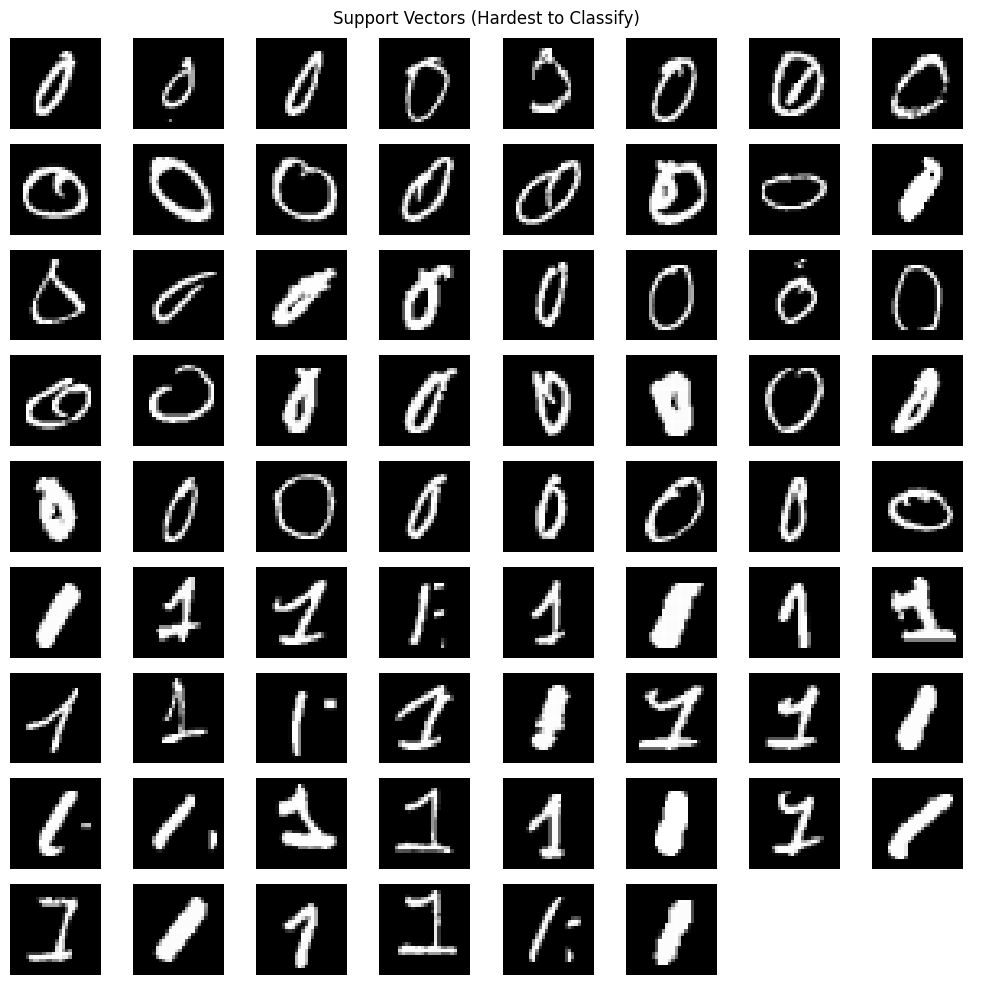

In [ ]:
# Number of support vectors
n_support_vectors = len(support_vectors)

# Determine grid size dynamically
n_rows = int(np.ceil(np.sqrt(n_support_vectors)))
n_cols = int(np.ceil(n_support_vectors / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.ravel()

# Plot each support vector
for i in range(n_support_vectors):
    axes[i].imshow(support_vectors[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

# Turn off unused subplots
for i in range(n_support_vectors, len(axes)):
    axes[i].axis('off')

plt.suptitle("Support Vectors (Hardest to Classify)")
plt.tight_layout()
plt.show()

### Plot Dual Coefficients (Lagrange Multipliers)

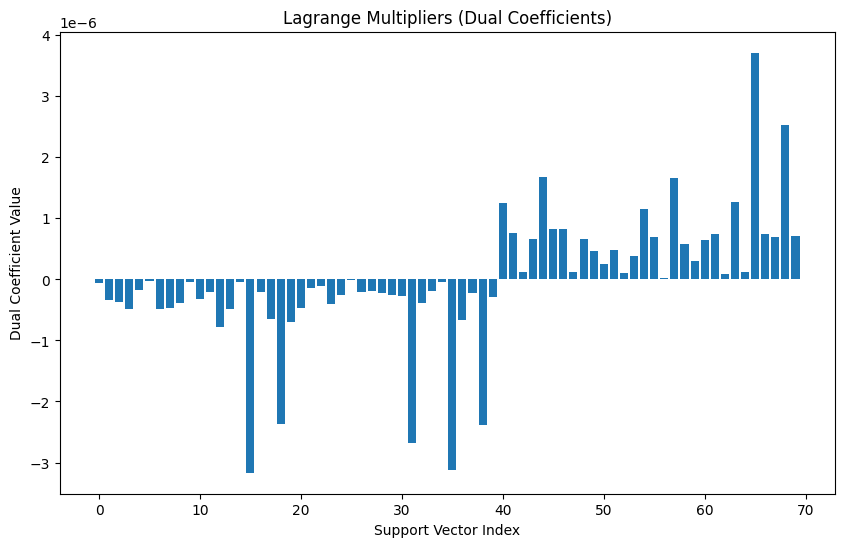

In [ ]:
dual_coeffs = svm_clf.dual_coef_

plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coeffs[0])), dual_coeffs[0])
plt.title("Lagrange Multipliers (Dual Coefficients)")
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.show()

### Compute and Plot Discriminant Values

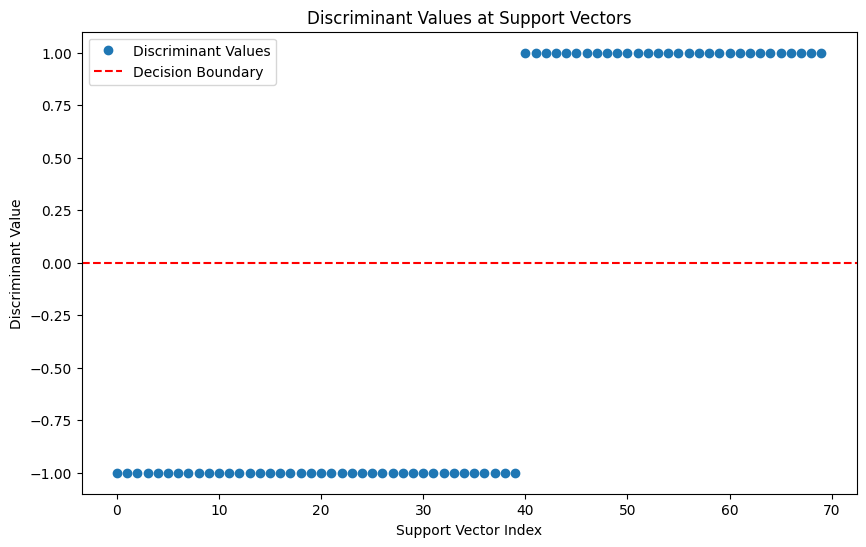

In [ ]:
discriminant_values = svm_clf.decision_function(support_vectors)

plt.figure(figsize=(10, 6))
plt.plot(discriminant_values, 'o', label='Discriminant Values')
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Discriminant Values at Support Vectors")
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.legend()
plt.show()

# Explanation:
# The discriminant values for support vectors lie close to 0 because these points are on or near the margin boundary.

### Display the Weight Vector and Intercept

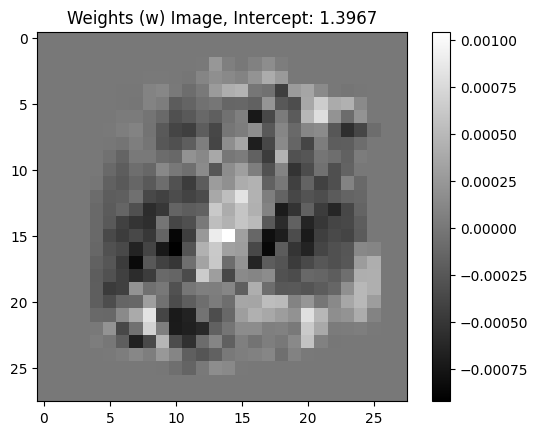

In [ ]:
# Extract weight vector and intercept
w = svm_clf.coef_[0]
intercept = svm_clf.intercept_

plt.imshow(w.reshape(28, 28), cmap='gray')
plt.title(f"Weights (w) Image, Intercept: {intercept[0]:.4f}")
plt.colorbar()
plt.show()

### Reduce Regularization Parameter 𝐶=1𝑒−8 and Repeat

Support Vectors with C=1: 70
Support Vectors with C=1e-8: 504


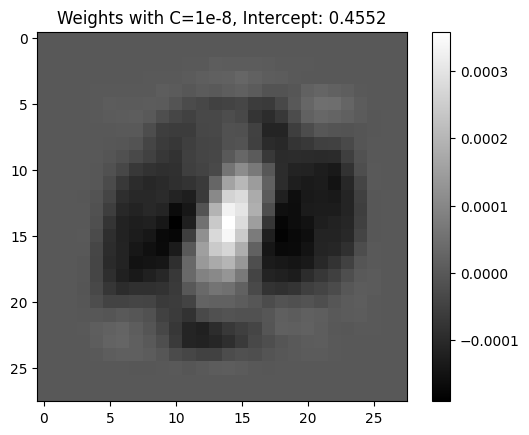

In [ ]:
# Train with reduced regularization
svm_clf_small_c = SVC(kernel='linear', C=1e-8, random_state=42)
svm_clf_small_c.fit(X_train, y_train)

# Extract new support vectors
support_vectors_small_c = svm_clf_small_c.support_vectors_

# Compare the number of support vectors
print("Support Vectors with C=1:", len(support_vectors))
print("Support Vectors with C=1e-8:", len(support_vectors_small_c))

# Extract new weights and intercept
w_small_c = svm_clf_small_c.coef_[0]
intercept_small_c = svm_clf_small_c.intercept_

plt.imshow(w_small_c.reshape(28, 28), cmap='gray')
plt.title(f"Weights with C=1e-8, Intercept: {intercept_small_c[0]:.4f}")
plt.colorbar()
plt.show()

# Explanation:
# Reducing C makes the margin wider and more support vectors are chosen. The weights become smaller as regularization penalizes large coefficients.

### Find Optimal Regularization Parameter Using Validation Data

Optimal Regularization Parameter (C): 1e-05


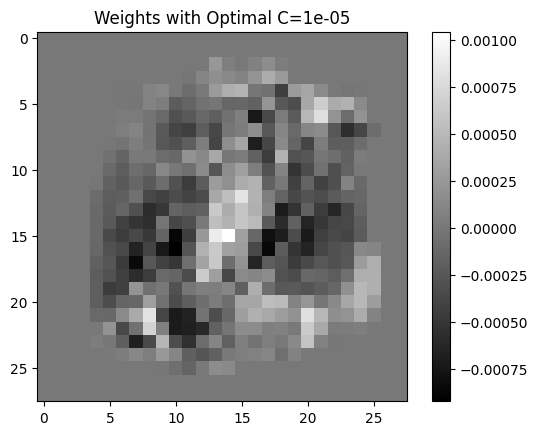

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {'C': np.logspace(-8, 2, 11)}
grid_search = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['C']
print("Optimal Regularization Parameter (C):", best_c)

# Train with optimal C
svm_clf_opt = SVC(kernel='linear', C=best_c, random_state=42)
svm_clf_opt.fit(X_train, y_train)

# Display the weight vector for optimal C
w_opt = svm_clf_opt.coef_[0]

plt.imshow(w_opt.reshape(28, 28), cmap='gray')
plt.title(f"Weights with Optimal C={best_c}")
plt.colorbar()
plt.show()

### Evaluate Accuracy

In [ ]:
# Evaluate on validation and test data
val_score = svm_clf_opt.score(X_val, y_val)
test_score = svm_clf_opt.score(X_test, y_test)

print(f"Validation Accuracy: {val_score*100:.2f}%")
print(f"Test Accuracy: {test_score*100:.2f}%")

Validation Accuracy: 99.86%
Test Accuracy: 99.80%


##  Two class classification with kernel classifiers

### Train Kernel SVMs (Poly and RBF)

In [ ]:
# Train SVM with Polynomial Kernel
poly_svm = SVC(kernel='poly', degree=3, C=1, random_state=42)  # Degree 3 polynomial kernel
poly_svm.fit(X_train, y_train)

# Extract support vectors for poly kernel
support_vectors_poly = poly_svm.support_vectors_

In [ ]:
# Train SVM with RBF Kernel
rbf_svm = SVC(kernel='rbf', C=1, random_state=42)  # RBF kernel
rbf_svm.fit(X_train, y_train)

# Extract support vectors for RBF kernel
support_vectors_rbf = rbf_svm.support_vectors_

### Display Support Vectors as Images

#### Polynomial Kernel

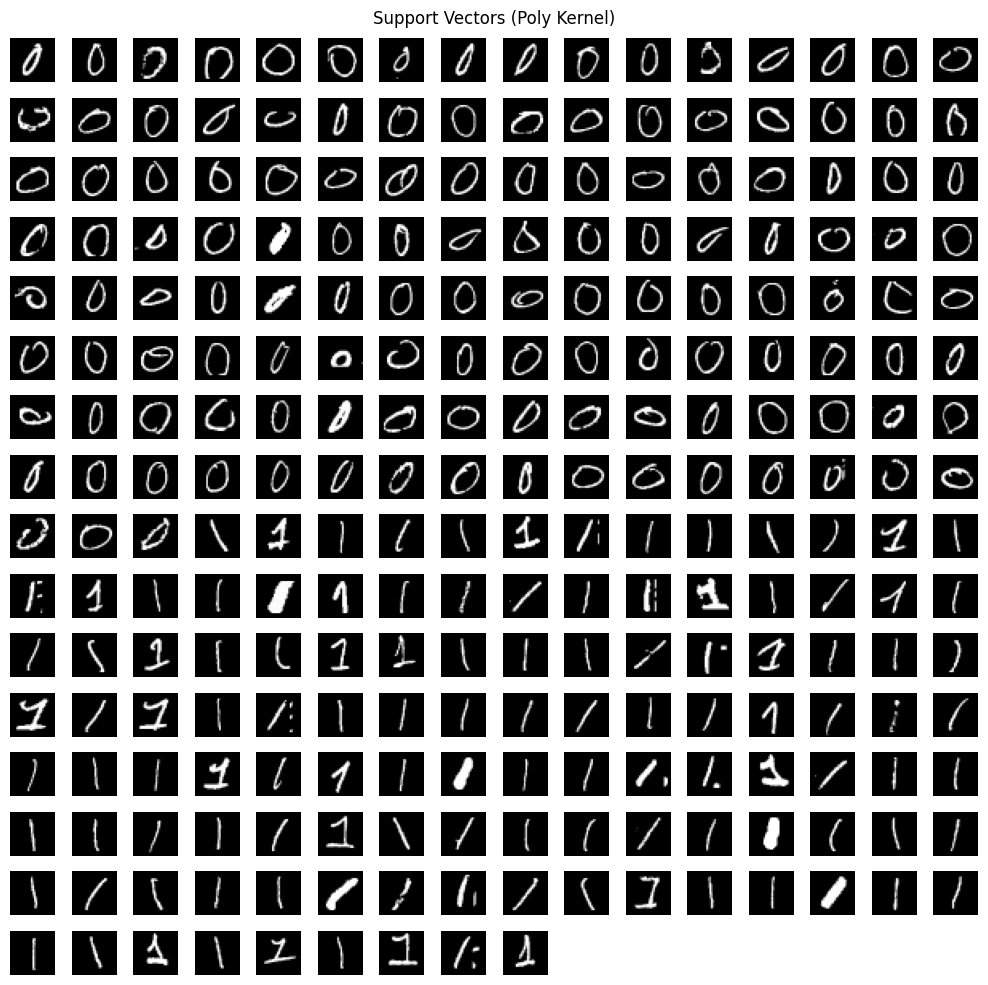

In [ ]:
n_support_vectors_poly = len(support_vectors_poly)
n_rows_poly = int(np.ceil(np.sqrt(n_support_vectors_poly)))
n_cols_poly = int(np.ceil(n_support_vectors_poly / n_rows_poly))

fig, axes = plt.subplots(n_rows_poly, n_cols_poly, figsize=(10, 10))
axes = axes.ravel()

for i in range(n_support_vectors_poly):
    axes[i].imshow(support_vectors_poly[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

for i in range(n_support_vectors_poly, len(axes)):
    axes[i].axis('off')

plt.suptitle("Support Vectors (Poly Kernel)")
plt.tight_layout()
plt.show()


#### RBF Kernel

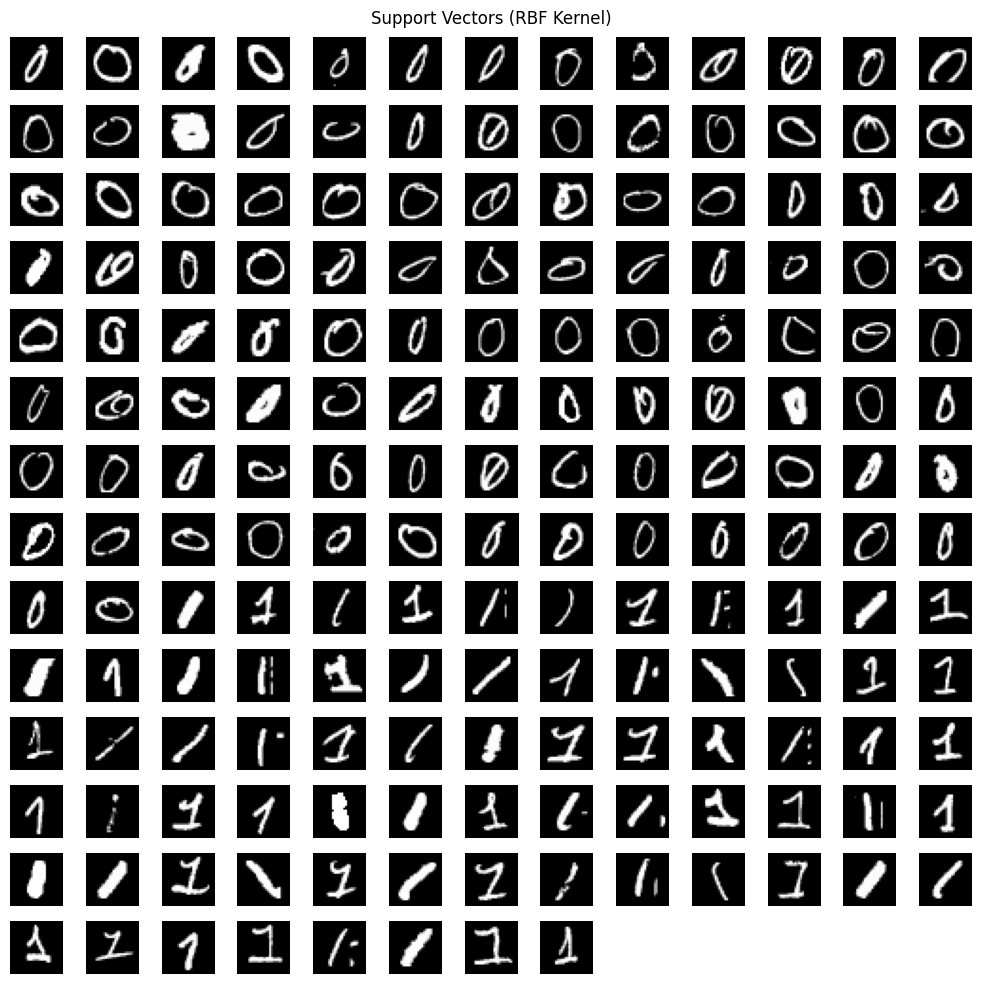

In [ ]:
n_support_vectors_rbf = len(support_vectors_rbf)
n_rows_rbf = int(np.ceil(np.sqrt(n_support_vectors_rbf)))
n_cols_rbf = int(np.ceil(n_support_vectors_rbf / n_rows_rbf))

fig, axes = plt.subplots(n_rows_rbf, n_cols_rbf, figsize=(10, 10))
axes = axes.ravel()

for i in range(n_support_vectors_rbf):
    axes[i].imshow(support_vectors_rbf[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

for i in range(n_support_vectors_rbf, len(axes)):
    axes[i].axis('off')

plt.suptitle("Support Vectors (RBF Kernel)")
plt.tight_layout()
plt.show()


### Plot Dual Coefficients (Lagrange Multipliers)

Represent the importance of each support vector in the classifier.

#### Polynomial Kernel

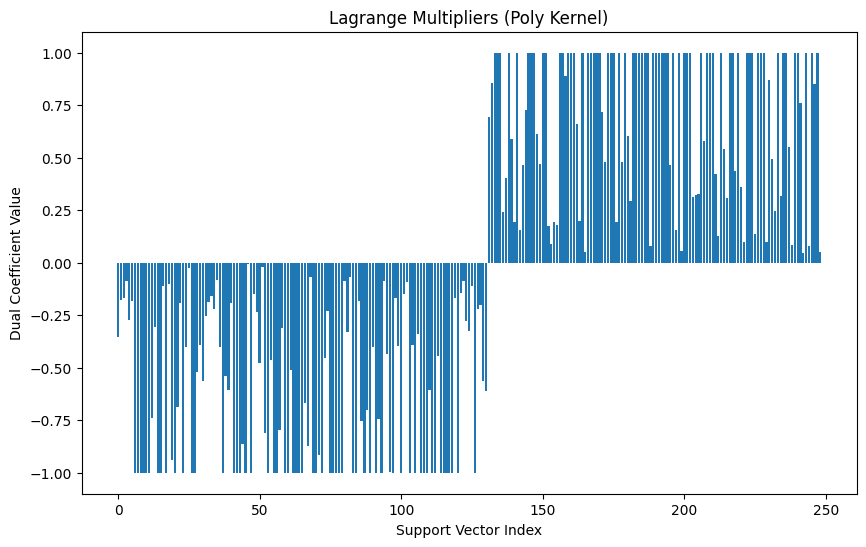

In [ ]:
dual_coeffs_poly = poly_svm.dual_coef_

plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coeffs_poly[0])), dual_coeffs_poly[0])
plt.title("Lagrange Multipliers (Poly Kernel)")
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.show()

#### RBF Kernel

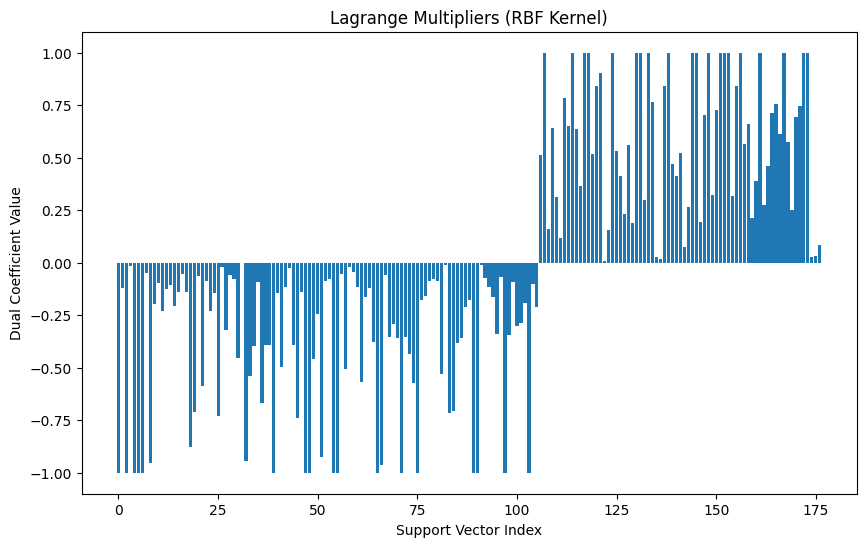

In [ ]:
dual_coeffs_rbf = rbf_svm.dual_coef_

plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coeffs_rbf[0])), dual_coeffs_rbf[0])
plt.title("Lagrange Multipliers (RBF Kernel)")
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.show()

### Plot Discriminant Values for Support Vectors

The decision function values show how close each support vector is to the decision boundary

#### Polynomial Kernel

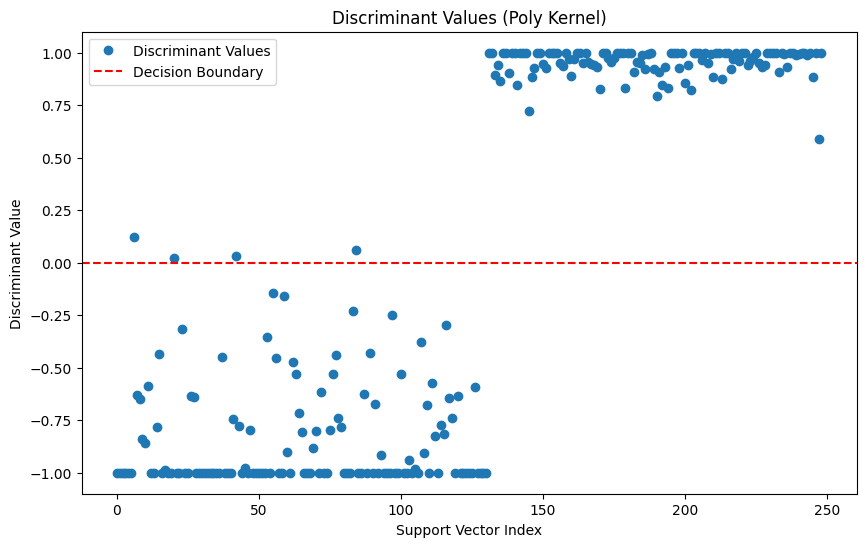

In [ ]:
discriminant_values_poly = poly_svm.decision_function(support_vectors_poly)

plt.figure(figsize=(10, 6))
plt.plot(discriminant_values_poly, 'o', label='Discriminant Values')
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Discriminant Values (Poly Kernel)")
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.legend()
plt.show()

#### RBF Kernel

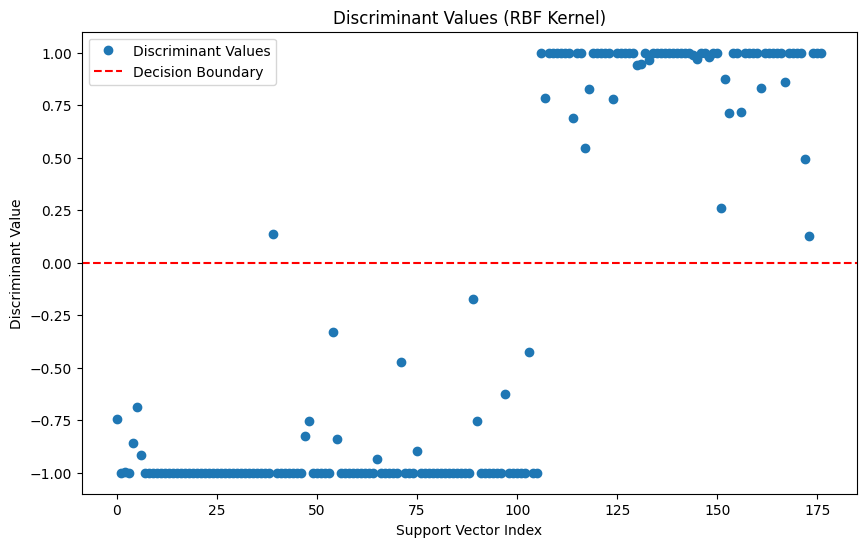

In [ ]:
discriminant_values_rbf = rbf_svm.decision_function(support_vectors_rbf)

plt.figure(figsize=(10, 6))
plt.plot(discriminant_values_rbf, 'o', label='Discriminant Values')
plt.axhline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title("Discriminant Values (RBF Kernel)")
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.legend()
plt.show()


### Optimize Regularization Parameter (𝐶)

Smaller 𝐶 results in a wider margin but may increase misclassification. Optimal
𝐶 balances margin width and classification accuracy.

#### Polynomial Kernel

In [ ]:
param_grid = {'C': np.logspace(-3, 3, 7)}  # Try values for C from 0.001 to 1000
grid_search_poly = GridSearchCV(SVC(kernel='poly', degree=3, random_state=42), param_grid, cv=5)
grid_search_poly.fit(X_train, y_train)

best_c_poly = grid_search_poly.best_params_['C']
print(f"Optimal Regularization Parameter (C) for Poly Kernel: {best_c_poly}")


Optimal Regularization Parameter (C) for Poly Kernel: 10.0


#### RBF Kernel

In [ ]:
grid_search_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5)
grid_search_rbf.fit(X_train, y_train)

best_c_rbf = grid_search_rbf.best_params_['C']
print(f"Optimal Regularization Parameter (C) for RBF Kernel: {best_c_rbf}")


Optimal Regularization Parameter (C) for RBF Kernel: 10.0


### Evaluate Accuracy

#### Polynomial Kernel

In [ ]:
poly_svm_opt = SVC(kernel='poly', degree=3, C=best_c_poly, random_state=42)
poly_svm_opt.fit(X_train, y_train)

val_score_poly = poly_svm_opt.score(X_val, y_val)
test_score_poly = poly_svm_opt.score(X_test, y_test)

print(f"Validation Accuracy (Poly Kernel): {val_score_poly*100:.2f}%")
print(f"Test Accuracy (Poly Kernel): {test_score_poly*100:.2f}%")

Validation Accuracy (Poly Kernel): 99.73%
Test Accuracy (Poly Kernel): 99.70%


#### RBF Kernel

In [ ]:
rbf_svm_opt = SVC(kernel='rbf', C=best_c_rbf, random_state=42)
rbf_svm_opt.fit(X_train, y_train)

val_score_rbf = rbf_svm_opt.score(X_val, y_val)
test_score_rbf = rbf_svm_opt.score(X_test, y_test)

print(f"Validation Accuracy (RBF Kernel): {val_score_rbf*100:.2f}%")
print(f"Test Accuracy (RBF Kernel): {test_score_rbf*100:.2f}%")

Validation Accuracy (RBF Kernel): 99.86%
Test Accuracy (RBF Kernel): 99.86%


## Multi-class classi cation

### Load and Restrict MNIST Data

In [ ]:
# Load MNIST dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Restrict to desired digits (e.g., 0, 1, 2, 3)
selected_digits = [0, 1, 2, 3]
X = X[np.isin(y.astype(int), selected_digits)]
y = y[np.isin(y.astype(int), selected_digits)].astype(int)

# Split data into train (70%), validation (10%), and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print(f"Training size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

Training size: 20237, Validation size: 2891, Test size: 5783


### Train Multi-class Linear Classifier (OVR and OVO)

#### One-vs-Rest (OVR)

In [ ]:
# Train linear SVM using OVR approach
svm_ovr = SVC(kernel='linear', decision_function_shape='ovr', C=1, random_state=42)
svm_ovr.fit(X_train, y_train)

# Extract coefficients and dual coefficients
dual_coeffs_ovr = svm_ovr.dual_coef_
coef_ovr = svm_ovr.coef_

print(f"Dual Coefficients (OVR): {dual_coeffs_ovr.shape}")
print(f"Weight Vectors (OVR): {coef_ovr.shape}")

#### One-vs-One (OVO)

In [ ]:
# Train linear SVM using OVO approach
svm_ovo = SVC(kernel='linear', decision_function_shape='ovo', C=1, random_state=42)
svm_ovo.fit(X_train, y_train)

# Extract coefficients and dual coefficients
dual_coeffs_ovo = svm_ovo.dual_coef_
coef_ovo = svm_ovo.coef_

print(f"Dual Coefficients (OVO): {dual_coeffs_ovo.shape}")
print(f"Weight Vectors (OVO): {coef_ovo.shape}")

### Plot Dual Coefficients and Weight Vectors

#### Dual Coefficients

* OVR has more coefficients because it trains a classifier for each class vs. the rest.

* OVO has fewer coefficients since it trains classifiers for every pair of classes.

In [ ]:
# OVR Dual Coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coeffs_ovr[0])), dual_coeffs_ovr[0])
plt.title("Dual Coefficients (OVR)")
plt.xlabel("Support Vector Index")
plt.ylabel("Coefficient Value")
plt.show()

# OVO Dual Coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coeffs_ovo[0])), dual_coeffs_ovo[0])
plt.title("Dual Coefficients (OVO)")
plt.xlabel("Support Vector Index")
plt.ylabel("Coefficient Value")
plt.show()

#### Weight Vectors

* Displayed as images, the weight vectors highlight the most significant features for classification.

In [ ]:
# Display weight vectors for each class
for i, w in enumerate(coef_ovr):
    plt.imshow(w.reshape(28, 28), cmap='gray')
    plt.title(f"Weights for Class {i} (OVR)")
    plt.colorbar()
    plt.show()

### Optimize Regularization Parameter 𝐶

* Higher 𝐶: Narrower margin, fewer misclassified points

* Lower 𝐶: Wider margin, allows more misclassification but improves generalization.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search for optimal C
param_grid = {'C': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(SVC(kernel='linear', decision_function_shape='ovr', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

optimal_c = grid_search.best_params_['C']
print(f"Optimal C: {optimal_c}")

# Retrain with optimal C
svm_opt = SVC(kernel='linear', decision_function_shape='ovr', C=optimal_c, random_state=42)
svm_opt.fit(X_train, y_train)

# Evaluate accuracy
train_acc = svm_opt.score(X_train, y_train)
val_acc = svm_opt.score(X_val, y_val)
test_acc = svm_opt.score(X_test, y_test)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

### Best SVM Classifier for All Digits

In [ ]:
# Grid search for SVM hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [3, 4],  # Only relevant for polynomial kernel
    'gamma': ['scale', 'auto']  # Only relevant for rbf and poly kernels
}

grid_search_full = GridSearchCV(SVC(decision_function_shape='ovr', random_state=42), param_grid, cv=3, verbose=3)
grid_search_full.fit(X_train, y_train)

best_params = grid_search_full.best_params_
print(f"Best Parameters: {best_params}")

# Train best SVM
svm_best = SVC(**best_params, decision_function_shape='ovr', random_state=42)
svm_best.fit(X_train, y_train)

# Evaluate
train_acc_full = svm_best.score(X_train, y_train)
val_acc_full = svm_best.score(X_val, y_val)
test_acc_full = svm_best.score(X_test, y_test)

print(f"Training Accuracy: {train_acc_full*100:.2f}%")
print(f"Validation Accuracy: {val_acc_full*100:.2f}%")
print(f"Test Accuracy: {test_acc_full*100:.2f}%")